In [1]:
from ioutils import reader
from attrdict import AttrDict
from collections import defaultdict
import pandas
import pdc
from functools import reduce


# fetch data

In [2]:
(all_cases, all_programs, all_studies) = pdc.load_all()

print('all_cases', len(all_cases))
print('all_programs', len(all_programs))
print('all_studies', len(all_studies))
print('all_files', reduce(lambda s, x: s + len(x.files) , all_studies, 0))


all_cases 977
all_programs 2
all_studies 20
all_files 37099


# assert that all cases exist within known projects

In [3]:
program_project = set()
for program in all_programs:
    for project in program.projects:
        program_project.add(project.project_submitter_id)


case_project = defaultdict(int)
for c in all_cases:
    case_project[c.project_submitter_id] += 1

assert case_project.keys() == program_project

pandas.DataFrame(case_project, index=['case_counts']).fillna('')

,CPTAC-2,CPTAC-TCGA,PJ-CPTAC3,PJ25730263
case_counts,359,369,240,9


# map gdc project to pdc project

In [4]:

def counter_dict():
    return defaultdict(int)

sample_gdc_projects = defaultdict(counter_dict)
for c in all_cases:
    for s in c.samples:
        if s.gdc_project_id in ['', None]:
            s.gdc_project_id = 'N/A'
        sample_gdc_projects[c.project_submitter_id][s.gdc_project_id] += 1

pandas.DataFrame(sample_gdc_projects).fillna('')

,CPTAC-2,CPTAC-TCGA,PJ-CPTAC3,PJ25730263
N/A,589,,354,18
TCGA-BRCA,,105,,
TCGA-COAD,,60,,
TCGA-OV,,174,,
TCGA-READ,,30,,


In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx
G = nx.MultiDiGraph()

G.add_nodes_from(set([case.project_submitter_id for case in all_cases]), label='Project')
G.add_nodes_from(set([case.case_submitter_id for case in all_cases]), label='Case')

edges = G.add_edges_from([(case.project_submitter_id, case.case_submitter_id) for case in all_cases],label='cases')

def case_samples():
    for case in all_cases:
        for s in case.samples:
            yield (case.case_submitter_id, s.sample_id)

def case_diagnoses():
    for case in all_cases:
        for d in case.diagnoses:
            yield (case.case_submitter_id, d.diagnosis_id)
            
def case_demographics():
    for case in all_cases:
        for d in case.demographics:
            yield (case.case_submitter_id, d.demographic_id)


            
def sample_aliquots():
    for case in all_cases:
        for s in case.samples:
            for a in s.aliquots:
                yield (s.sample_id, a.aliquot_id)

def aliquot_studies():
    for s in all_studies:
        for bs in s.biospecimens:
            yield (bs.aliquot_id, s.study_submitter_id)            


def study_files():
    for s in all_studies:
        for f in s.files:
            yield (s.study_submitter_id, f.file_id)            

            
G.add_nodes_from([case_sample[1] for case_sample in case_samples()], label='Sample')
edges = G.add_edges_from([case_sample for case_sample in case_samples()],label='samples')

G.add_nodes_from([sample_aliquot[1] for sample_aliquot in sample_aliquots()], label='Aliquot')
edges = G.add_edges_from([sample_aliquot for sample_aliquot in sample_aliquots()],label='aliquots')

G.add_nodes_from([case_diagnosis[1] for case_diagnosis in case_diagnoses()], label='Diagnosis')
edges = G.add_edges_from([case_diagnosis for case_diagnosis in case_diagnoses()],label='diagnoses')

G.add_nodes_from([case_demographic[1] for case_demographic in case_demographics()], label='Demographic')
edges = G.add_edges_from([case_demographic for case_demographic in case_demographics()],label='demographics')

G.add_nodes_from([aliquot_study[1] for aliquot_study in aliquot_studies()], label='Study')
edges = G.add_edges_from([aliquot_study for aliquot_study in aliquot_studies()],label='studies')

G.add_nodes_from([study_file[1] for study_file in study_files()], label='File')
edges = G.add_edges_from([study_file for study_file in study_files()],label='files')


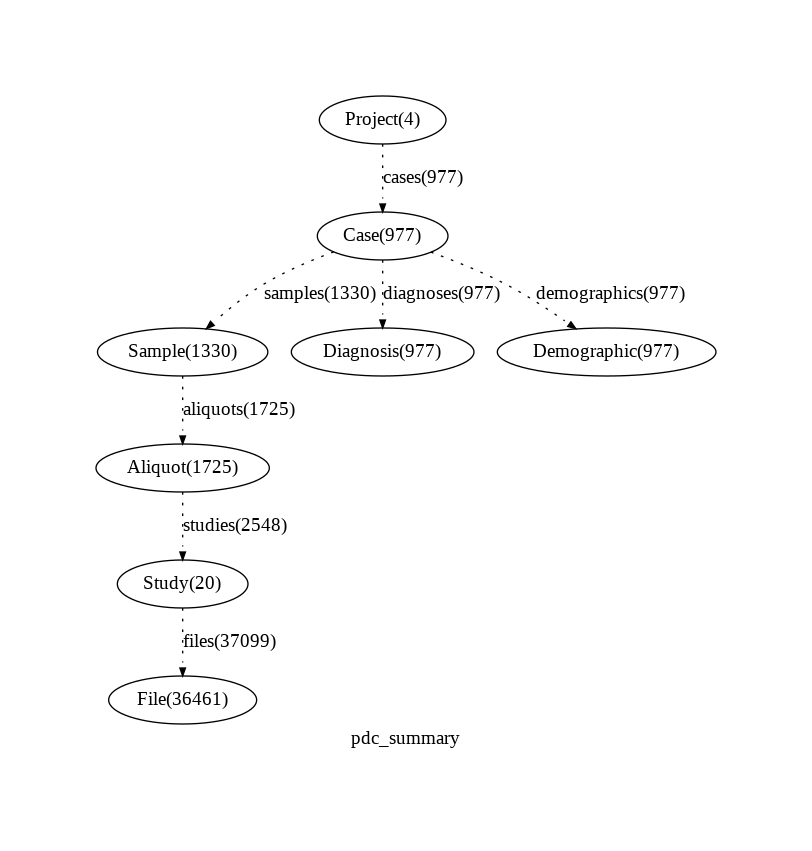

In [6]:
from graph_summarizer import summarize_graph, draw_summary
draw_summary(summarize_graph(G), 'pdc_summary')